# VeriRegime - 4小时波动率预测CNN训练

本notebook使用模块化组件训练4小时波动率预测模型

**任务**: 预测未来4小时BTC波动率（低/高）  
**阈值**: 0.05% (平衡分布，训练稳定)  
**标签分布**: 低波动50% vs 高波动50%  
**目标**: 准确率 ≥ 65%，理想 ≥ 70%


## 1. 导入依赖


In [1]:
import sys
sys.path.append('..')  # 添加项目根目录

import torch
import platform

# 导入训练模块
from train import CNNVolatility, create_dataloaders, Trainer

print(f"PyTorch版本: {torch.__version__}")
print(f"系统: {platform.system()}")


PyTorch版本: 2.9.1
系统: Darwin


## 2. 配置参数


In [2]:
# 数据配置 - 4小时波动率预测
FEATURE_COLS = ['ema_5', 'ema_10', 'ema_20', 'rsi', 'macd', 'volume_ma_5', 'volume_ma_10']
SEQ_LENGTH = 240  # 4小时 = 240分钟
BATCH_SIZE = 512

# 训练配置
EPOCHS = 50
LR = 1e-3
EARLY_STOP_PATIENCE = 10

# 路径配置
TRAIN_CSV = '../data/train.csv'
VAL_CSV = '../data/val.csv'
TEST_CSV = '../data/test.csv'

# 设备配置
if platform.system() == 'Darwin' and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print("🍎 使用MPS (Apple Silicon)")
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("🚀 使用CUDA")
else:
    DEVICE = torch.device('cpu')
    print("💻 使用CPU")

print(f"\n配置:")
print(f"  预测窗口: {SEQ_LENGTH}分钟 (4小时)")
print(f"  波动率阈值: 0.05%")
print(f"  批次大小: {BATCH_SIZE}")
print(f"  标签分布: ~50% 低波动, ~50% 高波动")


🍎 使用MPS (Apple Silicon)

配置:
  预测窗口: 240分钟 (4小时)
  波动率阈值: 0.05%
  批次大小: 512
  标签分布: ~50% 低波动, ~50% 高波动


## 3. 加载数据


In [3]:
print("加载数据...")

train_loader, val_loader, test_loader, class_weights, stats = create_dataloaders(
    train_csv=TRAIN_CSV,
    val_csv=VAL_CSV,
    test_csv=TEST_CSV,
    feature_cols=FEATURE_COLS,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

print(f"\n数据统计:")
print(f"  训练集: {stats['train_size']:,} 样本")
print(f"  验证集: {stats['val_size']:,} 样本") 
print(f"  测试集: {stats['test_size']:,} 样本")
print(f"  类别权重: {[f'{w:.3f}' for w in class_weights]}")


加载数据...

数据统计:
  训练集: 681,105 样本
  验证集: 145,763 样本
  测试集: 145,763 样本
  类别权重: ['0.931', '1.080']


## 4. 创建模型


In [4]:
model = CNNVolatility(input_channels=len(FEATURE_COLS), seq_length=SEQ_LENGTH)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型参数量: {total_params:,}")


模型参数量: 35,778


## 5. 训练模型


In [5]:
config = {'lr': LR, 'weight_decay': 1e-4}

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    class_weights=class_weights,
    config=config
)

print("\n开始训练...")
best_f1 = trainer.train(epochs=EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)



开始训练...

Epoch 1/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 94.76it/s] 


训练 - Loss: 0.4867 | Acc: 75.68%
验证 - Loss: 0.5568 | Acc: 72.96% | F1: 0.7061
✅ 最佳模型已保存 (F1: 0.7061)

Epoch 2/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:02<00:00, 95.80it/s] 


训练 - Loss: 0.4621 | Acc: 77.64%
验证 - Loss: 0.5144 | Acc: 74.53% | F1: 0.7344
✅ 最佳模型已保存 (F1: 0.7344)

Epoch 3/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 85.62it/s] 


训练 - Loss: 0.4529 | Acc: 78.31%
验证 - Loss: 0.5342 | Acc: 73.45% | F1: 0.7144

Epoch 4/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 93.41it/s] 


训练 - Loss: 0.4453 | Acc: 78.75%
验证 - Loss: 0.5177 | Acc: 74.08% | F1: 0.7369
✅ 最佳模型已保存 (F1: 0.7369)

Epoch 5/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 90.50it/s] 


训练 - Loss: 0.4386 | Acc: 79.27%
验证 - Loss: 0.5454 | Acc: 74.14% | F1: 0.7257

Epoch 6/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 92.60it/s] 


训练 - Loss: 0.4304 | Acc: 79.70%
验证 - Loss: 0.5691 | Acc: 73.39% | F1: 0.7094

Epoch 7/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:02<00:00, 101.72it/s]


训练 - Loss: 0.4232 | Acc: 80.12%
验证 - Loss: 0.5459 | Acc: 73.92% | F1: 0.7223

Epoch 8/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 91.26it/s] 


训练 - Loss: 0.4174 | Acc: 80.45%
验证 - Loss: 0.5458 | Acc: 73.52% | F1: 0.7266

Epoch 9/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 94.28it/s] 


训练 - Loss: 0.4108 | Acc: 80.84%
验证 - Loss: 0.5837 | Acc: 73.56% | F1: 0.7189

Epoch 10/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 92.23it/s] 


训练 - Loss: 0.4045 | Acc: 81.22%
验证 - Loss: 0.6055 | Acc: 73.38% | F1: 0.7157

Epoch 11/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 92.66it/s] 


训练 - Loss: 0.3935 | Acc: 81.78%
验证 - Loss: 0.5734 | Acc: 73.22% | F1: 0.7203

Epoch 12/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 92.79it/s] 


训练 - Loss: 0.3898 | Acc: 82.02%
验证 - Loss: 0.5623 | Acc: 72.81% | F1: 0.7197

Epoch 13/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 92.51it/s] 


训练 - Loss: 0.3860 | Acc: 82.23%
验证 - Loss: 0.6050 | Acc: 71.20% | F1: 0.6933

Epoch 14/50
------------------------------------------------------------


Validating: 100%|██████████| 285/285 [00:03<00:00, 80.78it/s] 

训练 - Loss: 0.3830 | Acc: 82.39%
验证 - Loss: 0.5999 | Acc: 71.15% | F1: 0.6938

早停触发！最佳epoch: 4

训练完成！最佳F1: 0.7369


## 6. 测试模型



测试最佳模型...


Testing: 100%|██████████| 285/285 [00:02<00:00, 105.36it/s]



测试结果
准确率: 74.62%
F1分数: 0.7375

混淆矩阵:
              预测LOW  预测HIGH
真实LOW        41095     18417
真实HIGH       18575     67676

分类报告:
              precision    recall  f1-score   support

         LOW     0.6887    0.6905    0.6896     59512
        HIGH     0.7861    0.7846    0.7854     86251

    accuracy                         0.7462    145763
   macro avg     0.7374    0.7376    0.7375    145763
weighted avg     0.7463    0.7462    0.7463    145763

✅ 结果图已保存: results/figures/training_results.png

🎉 模型达标！准确率: 74.62%


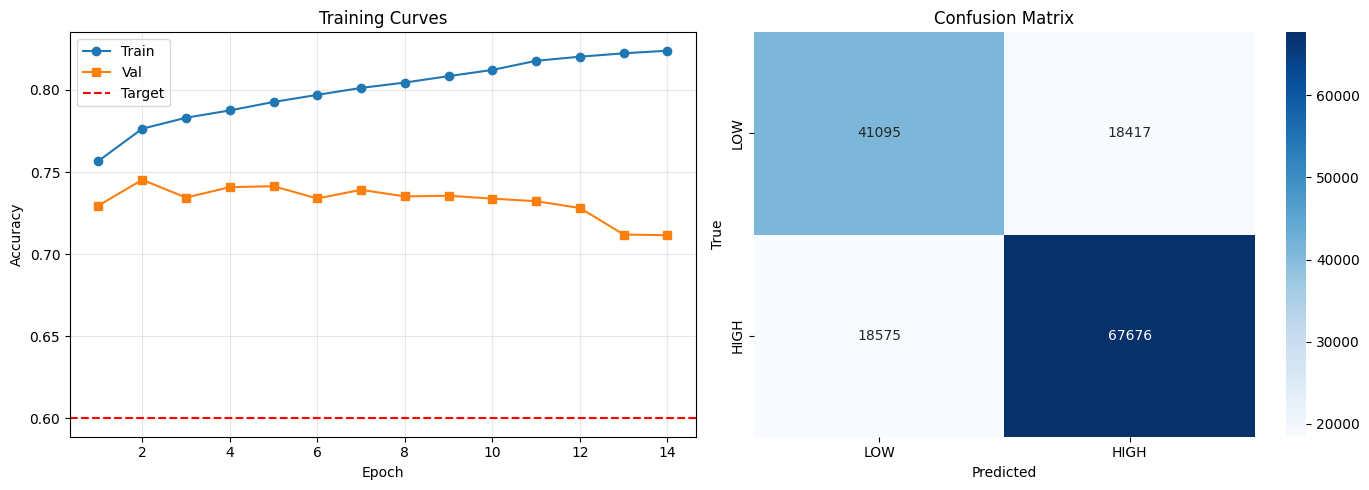

In [6]:
print("\n测试最佳模型...")

test_acc, test_f1 = trainer.test()

if test_acc >= 0.60:
    print(f"\n🎉 模型达标！准确率: {test_acc*100:.2f}%")
else:
    print(f"\n📊 准确率: {test_acc*100:.2f}% (目标: ≥60%)")
